In [33]:
#import lib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import re

In [34]:
vietnamese_dataset = "vietnamese_dataset.csv"
data = pd.read_csv(vietnamese_dataset)

In [35]:
data

,review,sentiment,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN
...,...,...,...,...
31455,Không đáng tiền.,NEG,1,NaN
31456,Quần rất đẹp.,POS,5,NaN
31457,Hàng đẹp đúng giá tiền.,POS,5,NaN
31458,Chất vải khá ổn.,POS,4,NaN


In [36]:
data=data[["review","sentiment"]]
data

,review,sentiment
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS
...,...,...
31455,Không đáng tiền.,NEG
31456,Quần rất đẹp.,POS
31457,Hàng đẹp đúng giá tiền.,POS
31458,Chất vải khá ổn.,POS


In [37]:
data.shape

(31460, 2)

In [38]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     31460 non-null  object
 1   sentiment  31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


In [40]:
missing_values=data.isnull().sum() # missing values

percent_missing = data.isnull().sum()/data.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %
review,0,0.0
sentiment,0,0.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12236\1941095395.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment',data=data, palette="PuRd")


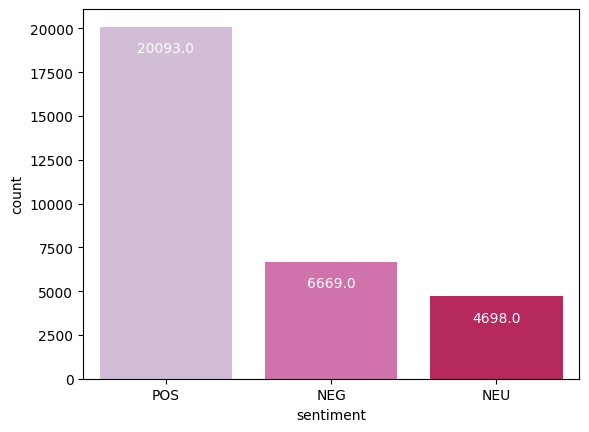

In [41]:
ax = sns.countplot(x='sentiment',data=data, palette="PuRd")
for p in ax.patches:
     ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+100), ha='center', va='top', color='white', size=10)
plt.show()

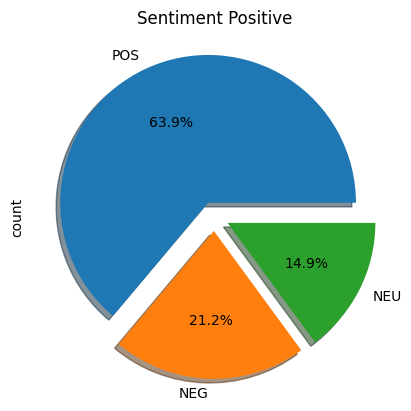

In [42]:
data["sentiment"].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',shadow=True)
plt.title('Sentiment Positive');

In [43]:
x_train, x_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)

In [44]:
def pre_process(text):
    text = text.lower()
    re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning function to the text data
x_train = x_train.apply(pre_process)
x_test = x_test.apply(pre_process)

In [63]:
vectorizer = TfidfVectorizer(max_features=5000)

x_train_tfidf = vectorizer.fit_transform(x_train)

x_test_tfidf = vectorizer.transform(x_test)

In [46]:
accuracies = {}
algo_time={}

In [47]:
def print_performance(yt,clf,clf_name):
    y_pred=clf.predict(x_test_tfidf)
    accuracies[clf_name]=accuracy_score(y_test, y_pred)*100
    print("\nAccuracy Score :",accuracies[clf_name],"%")
    print('\nClassification Report : ','\n',classification_report(yt,y_pred))

    confusionmatrix=confusion_matrix(yt,y_pred)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confusionmatrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusionmatrix.shape[0]):
        for j in range(confusionmatrix.shape[1]):
            ax.text(x=j, y=i,s=confusionmatrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)

LOGISTIC REGRESSION

Accuracy Score : 77.54291163382072 %

Classification Report :  
               precision    recall  f1-score   support

         NEG       0.67      0.74      0.71      1333
         NEU       0.47      0.19      0.27       978
         POS       0.84      0.93      0.88      3981

    accuracy                           0.78      6292
   macro avg       0.66      0.62      0.62      6292
weighted avg       0.74      0.78      0.75      6292



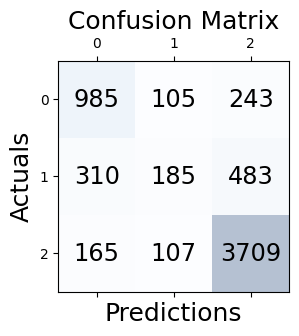

In [64]:
print("LOGISTIC REGRESSION")
start = time.time()
model_LR = LogisticRegression(max_iter=1000, random_state=42)
model_LR.fit(x_train_tfidf, y_train)
end = time.time()
print_performance(y_test,model_LR,'LOGISTIC REGRESSION')
algo_time['LOGISTIC REGRESSION']=end-start

NAIVE BAYES

Accuracy Score : 74.26891290527654 %

Classification Report :  
               precision    recall  f1-score   support

         NEG       0.63      0.65      0.64      1333
         NEU       0.45      0.07      0.12       978
         POS       0.78      0.94      0.85      3981

    accuracy                           0.74      6292
   macro avg       0.62      0.55      0.54      6292
weighted avg       0.70      0.74      0.69      6292



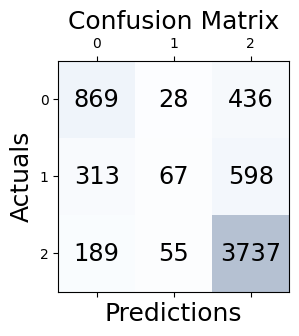

In [49]:
print("NAIVE BAYES")
start = time.time()
model_NB =  MultinomialNB()
model_NB.fit(x_train_tfidf, y_train)
end = time.time()
print_performance(y_test,model_NB,"NAIVE BAYES")
algo_time["NAIVE BAYES"]=end-start

In [50]:
import plotly.express as px
fig = px.bar(x=list(accuracies.keys()), y=list(accuracies.values()))
fig.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig.update_layout(title="Accuracy Comparision", xaxis_title="Model", yaxis_title="Accuracy")
fig.show()

In [51]:
fig = px.bar(x=list(algo_time.keys()), y=list(algo_time.values()))
fig.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig.update_layout(title="Algorithm Time Comparision", xaxis_title="Model", yaxis_title="")
fig.show()

In [52]:
def predict_rating(review):
    review_tfidf = vectorizer.transform([review])
    predicted_rating = model_LR.predict(review_tfidf)
    return predicted_rating

In [65]:
new_review = input("Enter your review: ")
predicted_rating = predict_rating(new_review)
print("Predicted rating:", predicted_rating)

Predicted rating: ['NEG']
